### Integration with a quantum circuit and automatic differentiation

In this tutorial we exploit the automatic differentiation of our quantum model with respect to the input data to perform the calculation of integrals.

---

The core idea is inspired by [J. M. Cruz-Martinez et al.](https://iopscience.iop.org/article/10.1088/2058-9565/ad5866) and consists in training the derivative of a quantum circuit output w.r.t. input data to approximate the integrand function of a target integration problem. Once the derivative of the circuit is trained to approximate the integrand, then the original circuit can be used to compute any definite integral value by applying the fundamental theorem of the integral calculus.

$$ I = \int g(x) dx $$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

2025-05-15 12:08:17.342560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747303697.362459   85129 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747303697.368327   85129 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747303697.383361   85129 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747303697.383391   85129 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747303697.383394   85129 computation_placer.cc:177] computation placer alr

We consider a dummy 1-dimensional target here.

In [2]:
def integrand_function(x):
    return 1/2*x + torch.sin(3 * x)

def integral_function(x):
    return x ** 2 / 4 - torch.cos(3 * x)/3 

def definite_integral(xa, xb):
    return integral_function(xb) - integral_function(xa)

npoints = 30
nqubits = 1
nlayers = 5

In [3]:
x = torch.linspace(0, 2, npoints)
g = integrand_function(x)
I = integral_function(x)

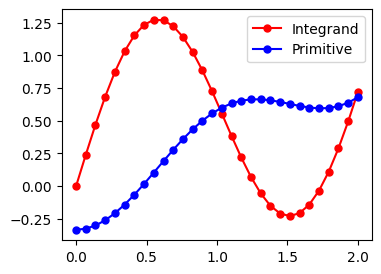

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(x, g, label="Integrand", c="red", marker=".", markersize=10)
plt.plot(x, I, label="Primitive", c="blue", marker=".", markersize=10)
plt.legend()
plt.show()

Then we use a data reuploading strategy to upload the data into a quantum circuit, alternating data-encoding gates with trainable blocks of gates in our circuit. 

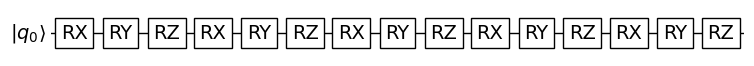

In [19]:
x_train = torch.linspace(0., 2., npoints, dtype=torch.float32).unsqueeze(1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = integrand_function(x_train)

# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    # backend=construct_backend("qiboml", platform="pytorch")
    backend=construct_backend("numpy")
)

circuit_structure = []
for _ in range(nlayers):
    circuit_structure.extend(
        [encoding_circ, trainable_circuit(entanglement=True)]
    )

# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
    differentiation=PSR()
)

model.draw()

optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99))
criterion = nn.MSELoss()

def prediction(model, x_i):
    y_pred = model(x_i)  # shape [1,1]
    # Compute dy_pred/dx_i without touching x_train.grad
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_i,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,     # so that gradients flow back into model.parameters()
        retain_graph=True      # if you really need to reuse the graph
    )[0]  # same shape as x_i
    return dydx

from copy import deepcopy

def loss_function(model, x, target):
    losses = []
    # Process each sample separately.
    for i, target_i in enumerate(target):
        # x_i and target_i are single samples (with proper shape)
        dydx = prediction(model, x_train[i])
        losses.append(criterion(dydx, target_i.unsqueeze(0)))
    return torch.stack(losses).mean()


We have a look to a first random guess of our model.

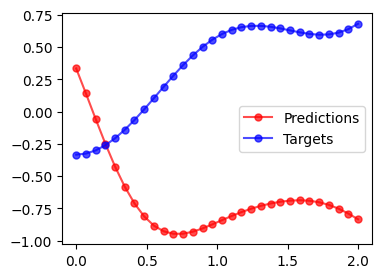

In [20]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

### Model training

In [22]:
for epoch in range(200):
    optimizer.zero_grad()
    
    # Compute loss using the wrapped loss function
    loss = loss_function(model, x_train, y_train)
    print(loss)
    
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

tensor(2.9926, grad_fn=<MeanBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### Predictions

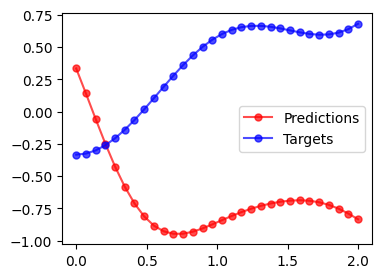

In [23]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

As expected, the solution is good but for a constant value. This is not a problem, because we need to use the model to compute definite integral values as follows:

In [9]:
x_a = torch.tensor(0.01)
x_b = torch.tensor(1.2)

print(
    "Def integral exact:", 
    definite_integral(x_a, x_b)
)
print(
    "Approx integral:", 
     (model(x_b) - model(x_a)).squeeze().detach().numpy()
)

Def integral exact: tensor(0.9921)
Approx integral: 0.9898888889322334
